# INDRA Database Summary

This notebook provides various summary statistics and charts over the INDRA Database (i.e., the causal relationships in INDRA CoGEx).

In [191]:
from indra_cogex.client import Neo4jClient, get_node_counter, get_stmts_for_stmt_hashes
import networkx as nx
from tabulate import tabulate
import datetime
import pandas as pd
import seaborn as sns
from textwrap import dedent
from indra.tools.assemble_corpus import run_preassembly
import matplotlib.pyplot as plt
from indra_cogex.info import env
from indra.assemblers.english import EnglishAssembler


import pystow
from matplotlib_inline.backend_inline import set_matplotlib_formats
from indra.sources import SOURCE_INFO
from indra.literature import pubmed_client
from indra.preassembler import Preassembler
from tqdm.auto import tqdm
from IPython.display import display, Markdown

set_matplotlib_formats('svg')

In [23]:
env()

Key,Value
OS,posix
Platform,Darwin
Release,22.1.0
Time,Thu Jan 5 12:00:51 2023
Python,3.11.0
INDRA Version,1.22.0
INDRA Git Hash,fe603882718e919bd342247be92884c0876150fa
INDRA CoGEx Version,1.0.0
INDRA CoGEx Git Hash,9c5f747046b64afb139c4df3c973086214a55f72
INDRA CoGEx Branch,interpro


In [73]:
source_types = {k: v['type'] for k, v in SOURCE_INFO.items()}

In [139]:
min_year = 1900
today_year = datetime.datetime.now().year
max_year = today_year - 2
today_year

2023

In [3]:
client = Neo4jClient()

INFO: [2023-01-05 11:50:53] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 11:50:53] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


In [35]:
%%time

publication_count_cypher = """
MATCH (p:Publication)
WHERE p.year IS NOT NULL
RETURN p.year, count(p.year)
ORDER BY p.year DESC
"""

year_df = pd.DataFrame(client.query_tx(publication_count_cypher), columns=["year", "publications"])
year_df

CPU times: user 8.62 ms, sys: 2.53 ms, total: 11.1 ms
Wall time: 28.8 s


In [39]:
%%time

evidence_count_cypher = """
MATCH (e:Evidence)-[:has_citation]-(p:Publication)
WHERE p.year IS NOT NULL
RETURN p.year, e.source_api, count(e.source_api)
ORDER BY p.year DESC
"""

df3 = pd.DataFrame(client.query_tx(evidence_count_cypher), columns=["year", "source_api", "count"])
df3["source_type"] = df3["source_api"].map(source_types)
df3

CPU times: user 25.8 ms, sys: 4.74 ms, total: 30.5 ms
Wall time: 1min 6s


,year,source_api,count
0,2022,reach,123929
1,2022,sparser,22347
2,2022,eidos,30118
3,2022,trips,45
4,2021,reach,838327
...,...,...,...
893,1911,reach,2
894,1911,sparser,1
895,1910,reach,3
896,1909,reach,3


In [89]:
%%time

statment_count_cypher = """
MATCH ()-[r:indra_rel]->()
MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
WHERE e.stmt_hash = r.stmt_hash 
    AND pub.year IS NOT NULL
RETURN pub.year, r.stmt_type, count(r.stmt_type)
ORDER BY pub.year DESC
"""

df4 = pd.DataFrame(client.query_tx(statment_count_cypher), columns=["year", "stmt_type", "count"])
df4

CPU times: user 50.9 ms, sys: 22.8 ms, total: 73.7 ms
Wall time: 3min 21s


,year,stmt_type,count
0,NaN,Inhibition,1870
1,NaN,Activation,3671
2,NaN,Complex,4816
3,NaN,IncreaseAmount,389
4,NaN,Phosphorylation,234
...,...,...,...
1469,1852.0,Inhibition,1
1470,1851.0,Inhibition,1
1471,1849.0,Activation,2
1472,1830.0,Activation,1


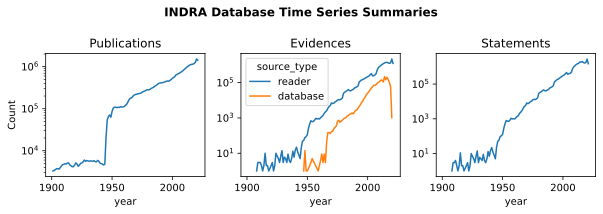

In [140]:
fig, ((lax, rax, lax_2)) = plt.subplots(1, 3, figsize=(8.5, 3), sharex=True)

sns.lineplot(
    data=year_df[year_df["year"].between(min_year, max_year)], 
    x="year", 
    y="publications",
    ax=lax,
)
lax.set_title("Publications")
lax.set_ylabel("Count")
lax.set_yscale("log")

sns.lineplot(
    data=df3[df3["year"].between(min_year, max_year)], 
    x="year", 
    y="count",
    hue="source_type",
    estimator="sum",
    errorbar=None,
    ax=rax,
)
rax.set_title("Evidences")
rax.set_ylabel("")
rax.set_yscale("log")


sns.lineplot(
    data=df4[df4["year"].between(min_year, max_year)],
    x="year", 
    y="count",
    estimator="sum",
    errorbar=None,
    ax=lax_2,
)
lax_2.set_title("Statements")
lax_2.set_ylabel("")
lax_2.set_yscale("log")

plt.suptitle("INDRA Database Time Series Summaries", fontweight="bold")
plt.tight_layout()
fig.savefig("/Users/cthoyt/Desktop/indra_db_time_summary.png", dpi=300)

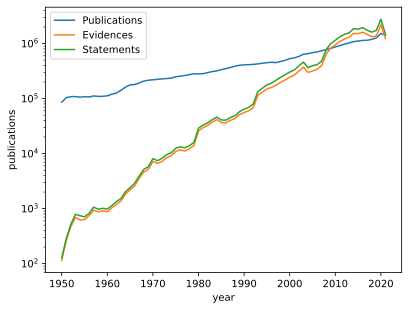

In [121]:
ax = sns.lineplot(
    data=year_df[year_df["year"].between(min_year, max_year)], 
    x="year", 
    y="publications",
    label="Publications",
)
sns.lineplot(
    data=df3[df3["year"].between(min_year, max_year)], 
    x="year", 
    y="count",
    estimator="sum",
    errorbar=None,
    ax=ax,
    label="Evidences",
)

sns.lineplot(
    data=df4[df4["year"].between(min_year, max_year)],
    x="year", 
    y="count",
    estimator="sum",
    errorbar=None,
    ax=ax,
    label="Statements"
)
ax.set_yscale("log")
plt.show()

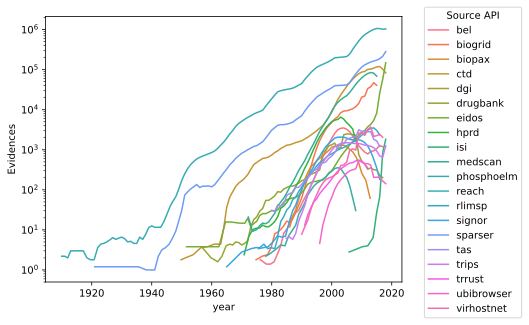

In [88]:
ax = sns.lineplot(
    data=(
        df3
        .loc[df3["year"].between(min_year, max_year), ["year", "source_api", "count"]]
        .groupby(["source_api"])
        .rolling(5)
        .mean()
    ),
    x="year", 
    y="count",
    hue="source_api",   
)
ax.set_ylabel("Evidences")
ax.set_yscale("log")
sns.move_legend(ax, "center right", bbox_to_anchor=(1.35, .45), title='Source API')
plt.show()

0       False
1       False
2       False
3       False
4       False
        ...  
1469    False
1470    False
1471    False
1472    False
1473    False
Name: year, Length: 1474, dtype: bool

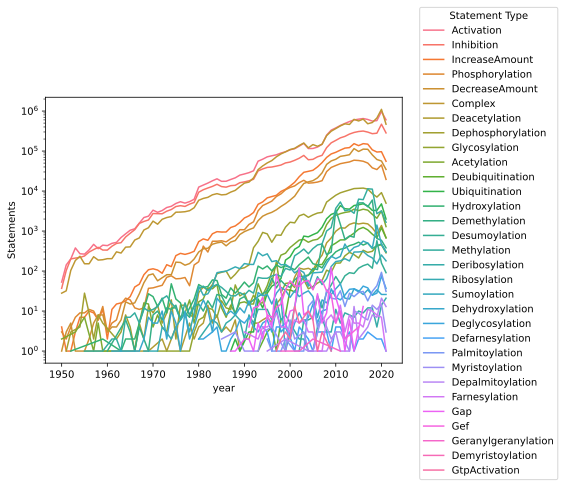

In [104]:
ax = sns.lineplot(
    data=df4[df4["year"].between(min_year, max_year)],
    x="year", 
    y="count",
    hue="stmt_type",   
)
ax.set_ylabel("Statements")
ax.set_yscale("log")
sns.move_legend(ax, "center right", bbox_to_anchor=(1.45, .45), title='Statement Type')
plt.show()

In [ ]:
# Distribution of number of evidences per publication (potentially stratify over time?)

# Time between first and second evidence for each statement

In [ ]:
%%time

publication_evidince_density = """
MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
WHERE e.stmt_hash = r.stmt_hash and pub.year < 1900
RETURN pub, collect(r.stmt_hash)
"""

res = client.query_tx(old_statement_cypher)
len(res)

# Old Statements

Get all statements with evidences that are from before a certain date. Many of the references point towards papers that only have digital scans.

In [196]:
old_statement_cutoff = 1920

In [197]:
%%time

old_statement_cypher = f"""
MATCH p=()-[r:indra_rel]->()
MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
WHERE e.stmt_hash = r.stmt_hash and pub.year < {old_statement_cutoff}
RETURN pub, collect(r.stmt_hash)
"""

old_statement_res = client.query_tx(old_statement_cypher)

CPU times: user 10.4 ms, sys: 7 ms, total: 17.4 ms
Wall time: 36.4 s


In [198]:
old_statement_res_processed = sorted(
    (
        pub["year"],
        pmid := pub["id"].removeprefix("pubmed:"), 
        pub["pmcid"],
        pubmed_client.get_title(pmid),
        run_preassembly(get_stmts_for_stmt_hashes(stmt_hashes)),
    )
    for pub, stmt_hashes in tqdm(old_statement_res)
)

INFO: [2023-01-05 14:58:47] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 14:58:47] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-05 14:58:47] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-05 14:58:47] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-05 14:58:47] indra_cogex.client.queries - got 1 evidences in 0.13 seconds
INFO: [2023-01-05 14:58:47] indra.tools.assemble_corpus - Combining duplicates on 1 statements...
INFO: [2023-01-05 14:58:47] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-05 14:58:47] indra.tools.assemble_corpus - Combining related on 1 statements...
Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 1269.08it/s]
INFO: [2023-01-05 14:58:47] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-05 14:58:47] indra.preassembler - Total comparisons: 0


INFO: [2023-01-05 14:58:50] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-05 14:58:50] indra.tools.assemble_corpus - Combining related on 1 statements...
Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 1830.77it/s]
INFO: [2023-01-05 14:58:50] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-05 14:58:50] indra.preassembler - Total comparisons: 0
INFO: [2023-01-05 14:58:50] indra.tools.assemble_corpus - Filtering 1 statements for top-level...
INFO: [2023-01-05 14:58:50] indra.tools.assemble_corpus - 1 statements after filter...
INFO: [2023-01-05 14:58:50] indra.tools.assemble_corpus - 1 top-level statements
INFO: [2023-01-05 14:58:50] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 14:58:50] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-05 14:58:50] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-

INFO: [2023-01-05 14:58:54] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 14:58:54] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-05 14:58:54] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-05 14:58:55] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-05 14:58:55] indra_cogex.client.queries - got 1 evidences in 0.13 seconds
INFO: [2023-01-05 14:58:55] indra.tools.assemble_corpus - Combining duplicates on 1 statements...
INFO: [2023-01-05 14:58:55] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-05 14:58:55] indra.tools.assemble_corpus - Combining related on 1 statements...
Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 1114.91it/s]
INFO: [2023-01-05 14:58:55] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-05 14:58:55] indra.preassembler - Total comparisons: 0


INFO: [2023-01-05 14:58:59] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-05 14:58:59] indra.tools.assemble_corpus - Combining related on 1 statements...
Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 1118.78it/s]
INFO: [2023-01-05 14:58:59] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-05 14:58:59] indra.preassembler - Total comparisons: 0
INFO: [2023-01-05 14:58:59] indra.tools.assemble_corpus - Filtering 1 statements for top-level...
INFO: [2023-01-05 14:58:59] indra.tools.assemble_corpus - 1 statements after filter...
INFO: [2023-01-05 14:58:59] indra.tools.assemble_corpus - 1 top-level statements
INFO: [2023-01-05 14:58:59] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 14:58:59] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-05 14:58:59] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-

INFO: [2023-01-05 14:59:05] indra.tools.assemble_corpus - 1 top-level statements
INFO: [2023-01-05 14:59:06] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 14:59:06] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-05 14:59:06] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-05 14:59:06] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-05 14:59:06] indra_cogex.client.queries - got 1 evidences in 0.14 seconds
INFO: [2023-01-05 14:59:06] indra.tools.assemble_corpus - Combining duplicates on 1 statements...
INFO: [2023-01-05 14:59:06] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-05 14:59:06] indra.tools.assemble_corpus - Combining related on 1 statements...
Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 1918.71it/s]
INFO: [2023-01-05 14:59:06] indra.preassembler - Found 0 refinement

INFO: [2023-01-05 14:59:10] indra.tools.assemble_corpus - 5 unique statements
INFO: [2023-01-05 14:59:10] indra.tools.assemble_corpus - Combining related on 5 statements...
Finding refinement relations: 100%|█████████████| 5/5 [00:00<00:00, 4280.78it/s]
INFO: [2023-01-05 14:59:10] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-05 14:59:10] indra.preassembler - Total comparisons: 0
INFO: [2023-01-05 14:59:10] indra.tools.assemble_corpus - Filtering 5 statements for top-level...
INFO: [2023-01-05 14:59:10] indra.tools.assemble_corpus - 5 statements after filter...
INFO: [2023-01-05 14:59:10] indra.tools.assemble_corpus - 5 top-level statements
INFO: [2023-01-05 14:59:10] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 14:59:10] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-05 14:59:10] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-

INFO: [2023-01-05 14:59:17] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 14:59:17] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-05 14:59:17] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-05 14:59:18] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-05 14:59:18] indra_cogex.client.queries - got 3 evidences in 0.14 seconds
INFO: [2023-01-05 14:59:18] indra.tools.assemble_corpus - Combining duplicates on 1 statements...
INFO: [2023-01-05 14:59:18] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-05 14:59:18] indra.tools.assemble_corpus - Combining related on 1 statements...
Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 4634.59it/s]
INFO: [2023-01-05 14:59:18] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-05 14:59:18] indra.preassembler - Total comparisons: 0


INFO: [2023-01-05 14:59:31] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-05 14:59:31] indra.tools.assemble_corpus - Combining related on 1 statements...
Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 6853.44it/s]
INFO: [2023-01-05 14:59:31] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-05 14:59:31] indra.preassembler - Total comparisons: 0
INFO: [2023-01-05 14:59:31] indra.tools.assemble_corpus - Filtering 1 statements for top-level...
INFO: [2023-01-05 14:59:31] indra.tools.assemble_corpus - 1 statements after filter...
INFO: [2023-01-05 14:59:31] indra.tools.assemble_corpus - 1 top-level statements
INFO: [2023-01-05 14:59:31] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-05 14:59:31] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-05 14:59:31] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-

In [202]:
old_statement_df = pd.DataFrame(
    [
        (
            year, pmid, pmc or "", title, len(stmts),
            EnglishAssembler(stmts).make_model()
        ) 
        for year, pmid, pmc, title, stmts in old_statement_res_processed
    ],
    columns=["year", "pubmed", "pmc", "title", "n_statements", "statments"],
)

display(Markdown(dedent(f"""\
    The INDRA Database contains {len(old_statement_df.index)} papers annotated as being published before {old_statement_cutoff}\
    that together contain {old_statement_df.n_statements.sum()} INDRA statements. The oldest paper is from\
    {old_statement_res_processed[0][0]} entitled *{old_statement_res_processed[0][3].rstrip(".")}*\
    ([pubmed:{old_statement_res_processed[0][1]}](https://bioregistry.io/pubmed:{old_statement_res_processed[0][1]}))\
    and contains the following statements:
    
    {EnglishAssembler(old_statement_res_processed[0][4]).make_model()}
"""
)))

old_statement_df.to_csv("/Users/cthoyt/Desktop/old_indra_statements.tsv", sep='\t', index=False)
old_statement_df.head(10)

The INDRA Database contains 47 papers annotated as being published before 1920    that together contain 63 INDRA statements. The oldest paper is from    1810 entitled *Observations on the Effects of Magnesia, in Preventing an Increased Formation of Uric Acid; with Some Remarks on the Composition of the Urine*    ([pubmed:30492701](https://bioregistry.io/pubmed:30492701))    and contains the following statements:

Magnesium oxide inhibits uric acid.


,year,pubmed,pmc,title,n_statements,statments
0,1810,30492701,PMC5694312,"Observations on the Effects of Magnesia, in Pr...",1,Magnesium oxide inhibits uric acid.
1,1830,30495358,PMC5671147,"Case of Intestinal Obstruction, Caused by Stri...",1,"Constriction, Pathologic activates casE."
2,1849,35374888,PMC8412535,Tetanus Produced by the Application of Nitrate...,2,Nitrate activates Tetanus. Silver(1+) activate...
3,1851,35375161,PMC8439798,On the Employment of Tartar Emetic to Relieve ...,1,Dipotassium bis[mu-tartrato(4-)]diantimonate(2...
4,1852,35375507,PMC8663383,On the Arrest of Typhus Fever by Quinine.,1,"Quinine inhibits Typhus, Epidemic Louse-Borne."
5,1855,35375820,PMC8676795,"A Respiratory Sound, Produced by a Tumor of th...",1,Neoplasms activates Respiratory Sounds.
6,1861,29647165,PMC5307054,On the Waxy or Amyloid Form of Bright's Disease.,1,ARID3A binds IAPP.
7,1864,29646175,PMC5311527,Further Observations on the Waxy or Amyloid Fo...,1,ARID3A binds IAPP.
8,1881,35826324,PMC8858189,Premature Labor Induced by Quinine.,1,"Quinine activates Obstetric Labor, Premature."
9,1884,17231514,PMC1288438,The Urea Elimination under the Use of Potassiu...,1,Urea inhibits potassium fluoride.
